In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  

In [2]:
order_products_train_df = pd.read_csv("C:/Users/herson/OneDrive/Bureau/Herson/data/Input/order_products__train.csv")
order_products_prior_df = pd.read_csv("C:/Users/herson/OneDrive/Bureau/Herson/data/Input/order_products__prior.csv")
orders_df = pd.read_csv("C:/Users/herson/OneDrive/Bureau/Herson/data/Input/orders.csv")
products_df = pd.read_csv("C:/Users/herson/OneDrive/Bureau/Herson/data/Input/products.csv")
aisles_df = pd.read_csv("C:/Users/herson/OneDrive/Bureau/Herson/data/Input/aisles.csv")
departments_df = pd.read_csv("C:/Users/herson/OneDrive/Bureau/Herson/data/Input/departments.csv")

In [3]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Order_products * Le fichier csv contient des informations plus détaillées sur les produits achetés dans la commande donnée ainsi que le statut de réapprovisionnement.

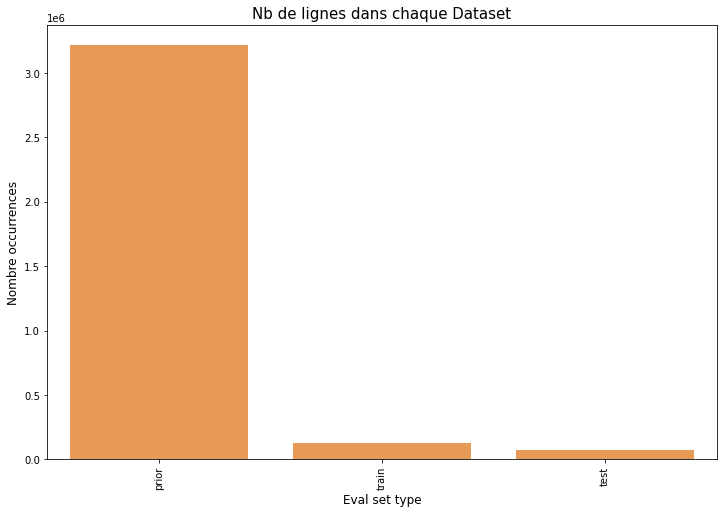

In [8]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Nombre occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Nb de lignes dans chaque Dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

Il y a donc au total 206 209 clients. Dont, le dernier achat de 131.209 clients est donné sous forme de train et nous devons prévoir pour le reste 75.000 clients.

Validons maintenant la réclamation selon laquelle 4 à 100 commandes d'un client sont passées.

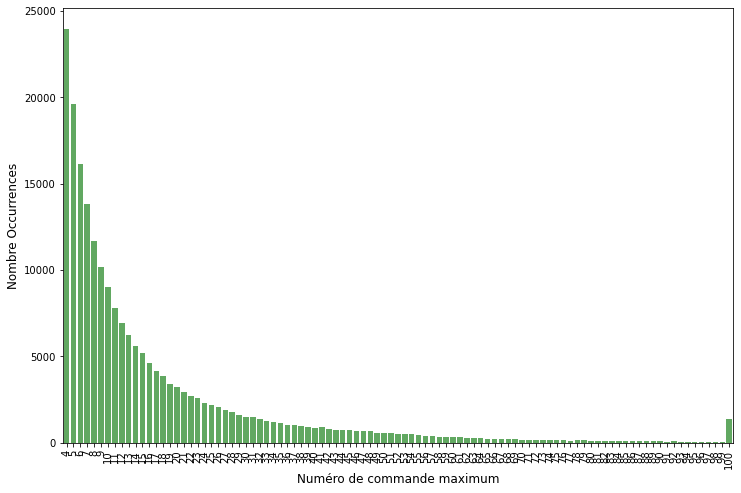

In [13]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Nombre Occurrences', fontsize=12)
plt.xlabel('Numéro de commande maximum', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Il n'y a donc pas de commandes inférieures à 4 et est plafonné à 100 comme indiqué dans la page de données.

Voyons maintenant comment les habitudes de commande changent avec le jour de la semaine.


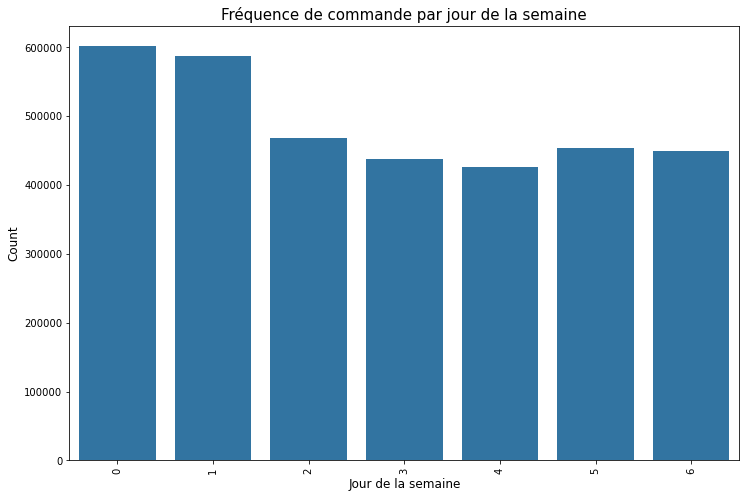

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Jour de la semaine', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Fréquence de commande par jour de la semaine", fontsize=15)
plt.show()

On dirait que 0 et 1 est samedi et dimanche lorsque les commandes sont élevées et faibles pendant mercredi.

Nous allons maintenant voir comment la distribution est par rapport à l'heure de la journée.

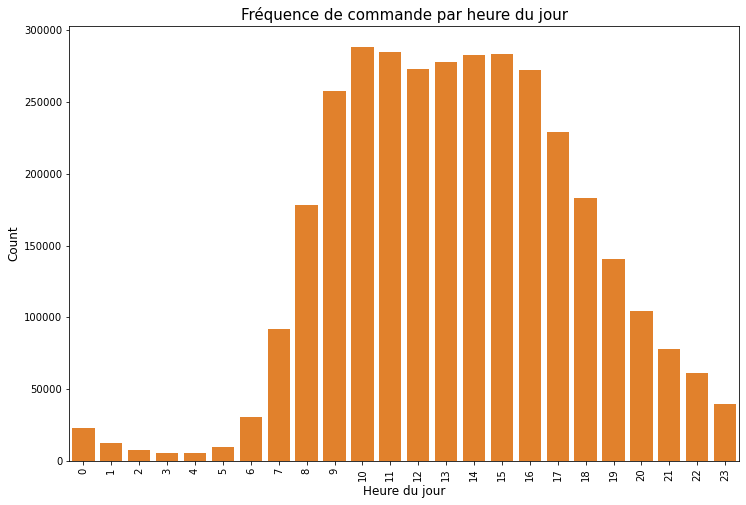

In [15]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Heure du jour', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Fréquence de commande par heure du jour", fontsize=15)
plt.show()

La majorité des commandes sont donc effectuées pendant la journée. Maintenant, combinons le jour de la semaine et l'heure de la journée pour voir la distribution.

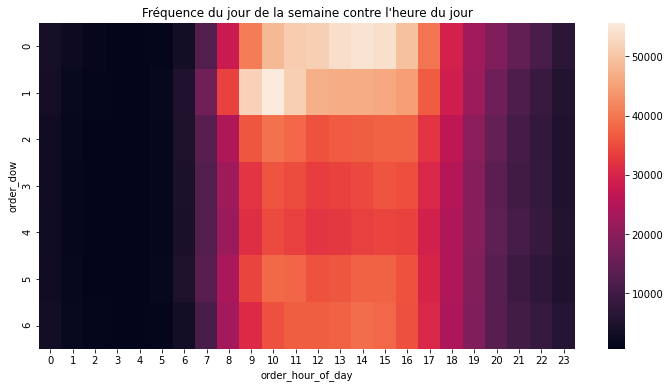

In [16]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Fréquence du jour de la semaine contre l'heure du jour")
plt.show()

Il semble que le samedi soir et le dimanche matin sont les heures de grande écoute pour les commandes.

Vérifions maintenant l'intervalle de temps entre les commandes.

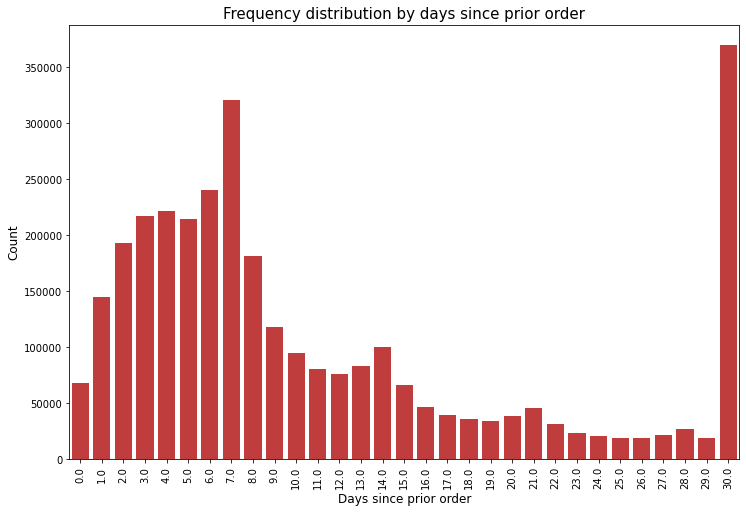

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

In [22]:
# pourcentage de nouvelles commandes dans le jeu précédent #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [23]:
# pourcentage de nouvelles commandes dans le train #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

En moyenne, environ 59% des produits d'une commande sont des produits commandés de nouveau.

Pas de produits commandés de nouveau:

Maintenant que 59% des produits ont été commandés à nouveau, il y aura également des situations où aucun des produits ne sera commandé à nouveau. Vérifions cela maintenant.

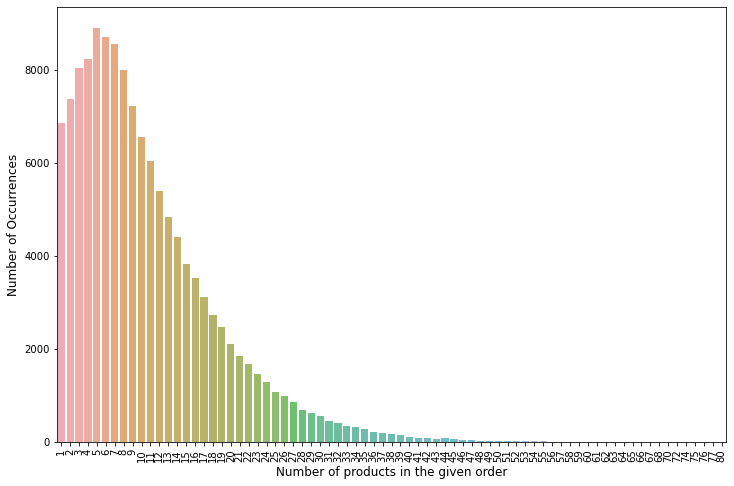

In [27]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Une distribution à droite avec la valeur maximale à 5.!

Avant d'explorer les détails du produit, examinons également les trois autres fichiers.

In [28]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [29]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [30]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Maintenant, fusionnons ces détails du produit avec les détails de order_prior.

In [31]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [32]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


La plupart d'entre eux sont des produits biologiques.! La majorité d'entre eux sont également des fruits.

Voyons maintenant les allées importantes.

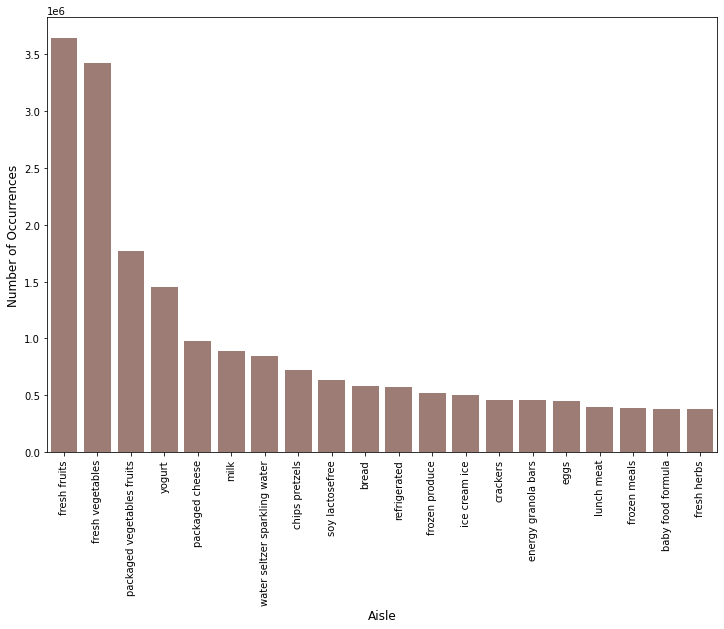

In [33]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Les deux allées supérieures sont des fruits frais et des légumes frais.!

Distribution des départements:

Vérifions maintenant la répartition par département.

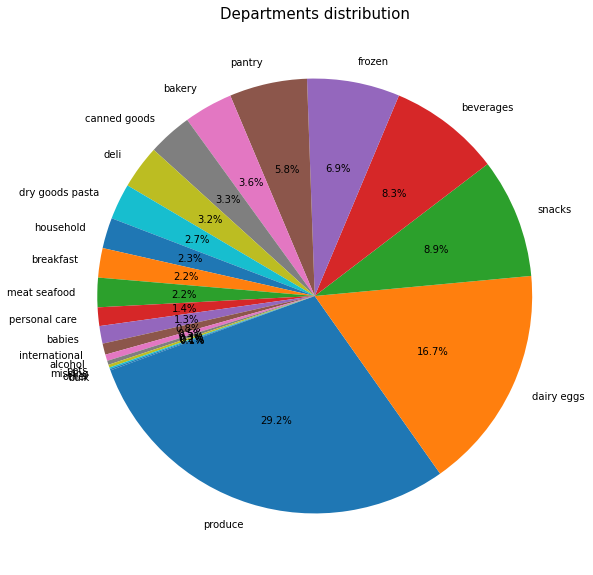

In [34]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

Produire est le plus grand département. Vérifions maintenant le pourcentage réorganisé de chaque département.

Ratio de réapprovisionnement par département:

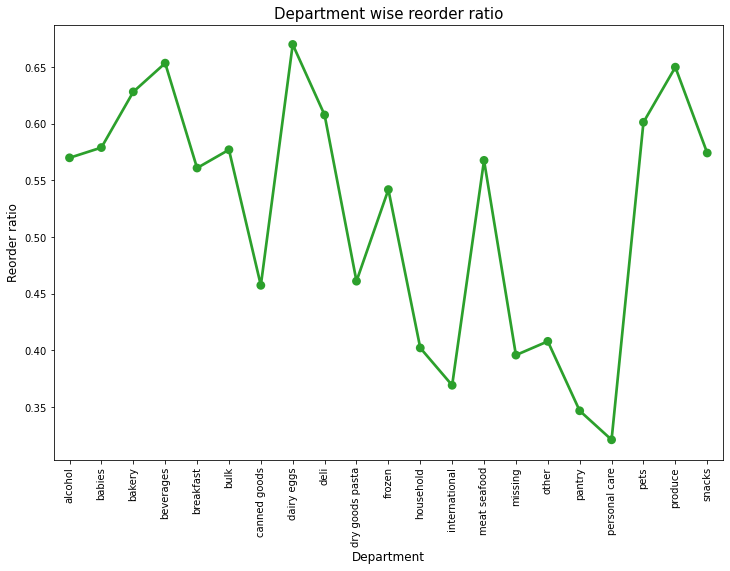

In [35]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Les soins personnels ont le taux de réapprovisionnement le plus bas et les œufs de produits laitiers ont le taux de réapprovisionnement le plus élevé.

Allée - Ratio de réorganisation:

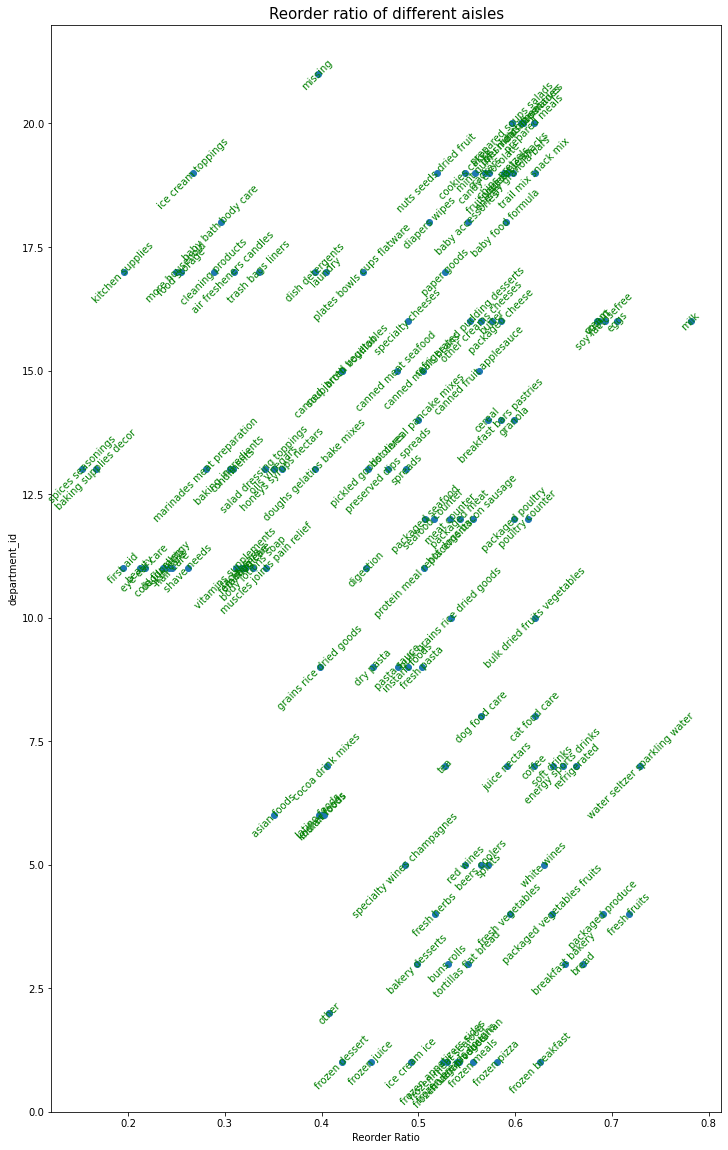

In [36]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

Rapport de réorganisation par variables basées sur le temps:

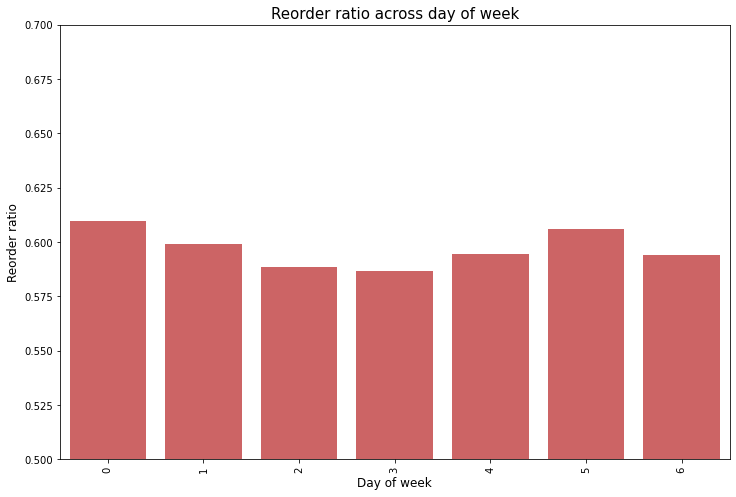

In [38]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

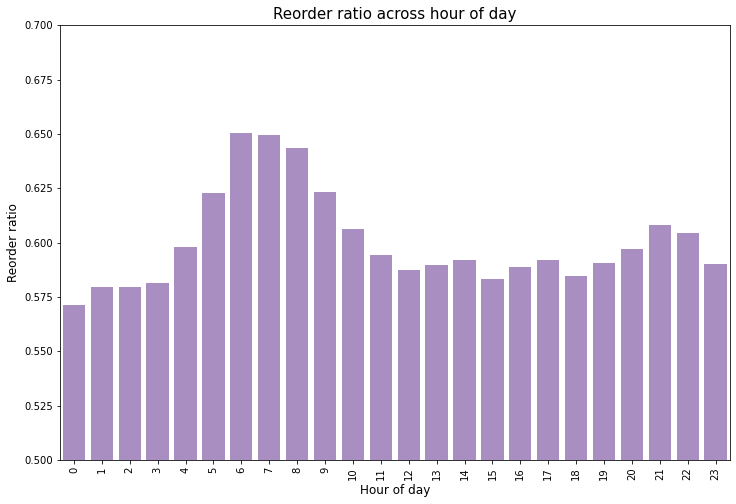

In [39]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

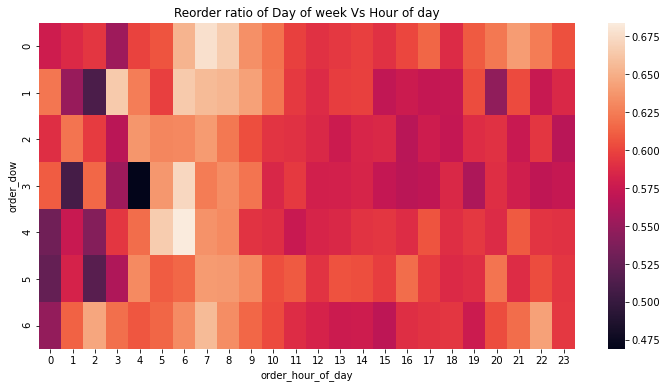

In [40]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

In [109]:
y_pred = xgb.predict(X_test)

In [110]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[1688  166  369]
 [ 183 1238  296]
 [ 260   52 1244]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      2223
           1       0.85      0.72      0.78      1717
           2       0.65      0.80      0.72      1556

    accuracy                           0.76      5496
   macro avg       0.76      0.76      0.76      5496
weighted avg       0.77      0.76      0.76      5496

0.7587336244541485
